# **Exploring Hurricane Tracks**

In this notebook, we reproduce some of the analysis carried out in "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al.

This notebook (a Python-based JupyterNotebook) provides a set of starter codes for [LEAP CPC Spring 2025](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges) [**Project 1**](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges#project-cycle-1-individual-notebook-for-exploratory-data-analysis) on

+ how to work with x-array data (given the hurricane tracks data),
+ how to visualize tracks and their moments,
+ how to carry out basic analysis on the hurricane data,
+ how to do k-means with the moments based on the paper's original idea.

All the codes in this notebook can be modified to implement research ideas.  



- Github sharing is recommended.
    - See our Github [tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md).
    - If you need help, please reach out to TA Xinyi Ke xk2161@columbia.edu.




# Step 0: Setup workspace

In [2]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)


Setup a subfolder for downloaded raw data and another subfolder for outputs. This prevents you from overwrites raw data by accident.

You can check that this new folder called 'data' was created. To view the files in your workspace, click on the 'File Browser' buttom at the left side-bar.

This folder will be used to store data which will be later downloaded.

---



# Step 1: Install packages, import packages and download data


## 1.1 Packages

Download the required packges.

In [2]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [4]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

## 1.2 Load Hurricane Data

Useful links to read more about data:

* [Official website for IBTrACS](https://www.ncdc.noaa.gov/ibtracs/). (where the data comes from)

* [Tracks in other basins for IBTrACs (other than NA)](https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/) (The data downloaded below covers the tracks in the basin 'NA' (North America). So, if you want to study tracks or hurricanes from other basins, this link might be helpful.)

* Another source of data: [HURDAT2](https://oasishub.co/dataset/hurdat-2-atlantic-hurricane-database/resource/2c865c53-3fc3-4e16-9ef5-0d76a47cfcf3) (not used in this notebook, but might be useful)



*   General documentation of the data: https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf
*   Detailed documentation on each variable(this is particularly helpful if you want to dig more into the dataset and find what problems you are interested in solving regarding the track data): https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_v04_column_documentation.pdf


In [8]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [5]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

Now, check the /data directory (left panell( to see if the data `NA_data.nc` has been saved there.

# Step 2: Visualization of hurricane tracks






In this section, the notebooks give examples on how to plot tracks on a map on locations specified by users.

All the codes in this section can be directly used or modified to allow more features in later works.

## 2.1 Map background

This function plots a background map with parameters label and extent.



*   **label**: boolean, to short label or not on the output map background
*   **extent**: this controls where the projection appears, i.e., which part of earth map should appear on the projection. Its four entries can be viewd as (starting_longitude, ending_longitude, starting_latitude, ending_latitude).



In [6]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

## 2.1.1 A simple example using the function.

Here, we plot a line between two Stanford and Berkeley using the above function.

Text(-122.1461, 37.4041, 'Stanford')

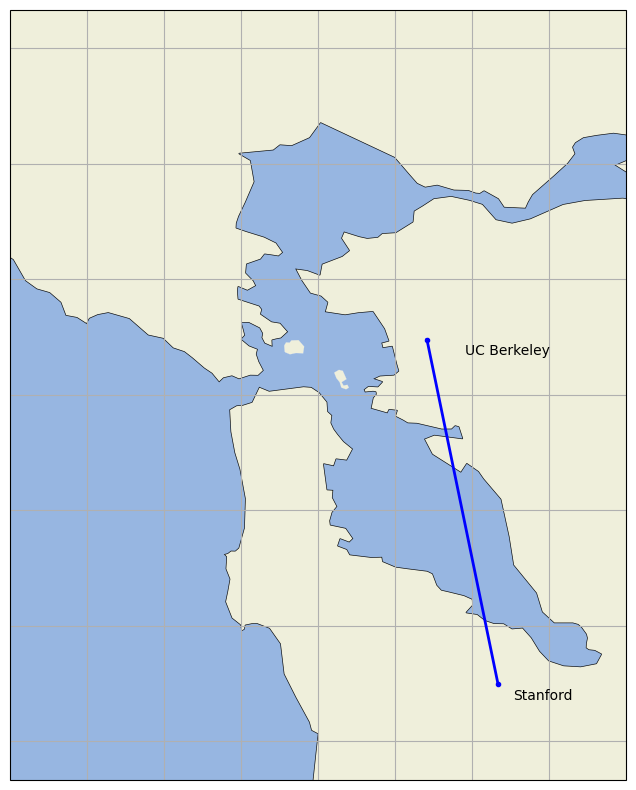

In [7]:
ax = map_background(extent=[-122.8, -122, 37.3, 38.3])

berkeley_lon, berkeley_lat = -122.2585, 37.8719
stanford_lon, stanford_lat = -122.1661, 37.4241

# plot the two universities as blue dots
ax.plot([berkeley_lon, stanford_lon], [berkeley_lat, stanford_lat],
         color='blue', linewidth=2, marker='.')
ax.text(berkeley_lon + 0.16, berkeley_lat - 0.02, 'UC Berkeley',
         horizontalalignment='right')
ax.text(stanford_lon + 0.02, stanford_lat - 0.02, 'Stanford',
         horizontalalignment='left')

\\

---

\\

## 2.2 Working with xarray data.

+ [Xarray documentation](https://xarray.pydata.org/en/stable/user-guide/terminology.html).
+ Read more about [data](https://earth-env-data-science.github.io/lectures/data.html).

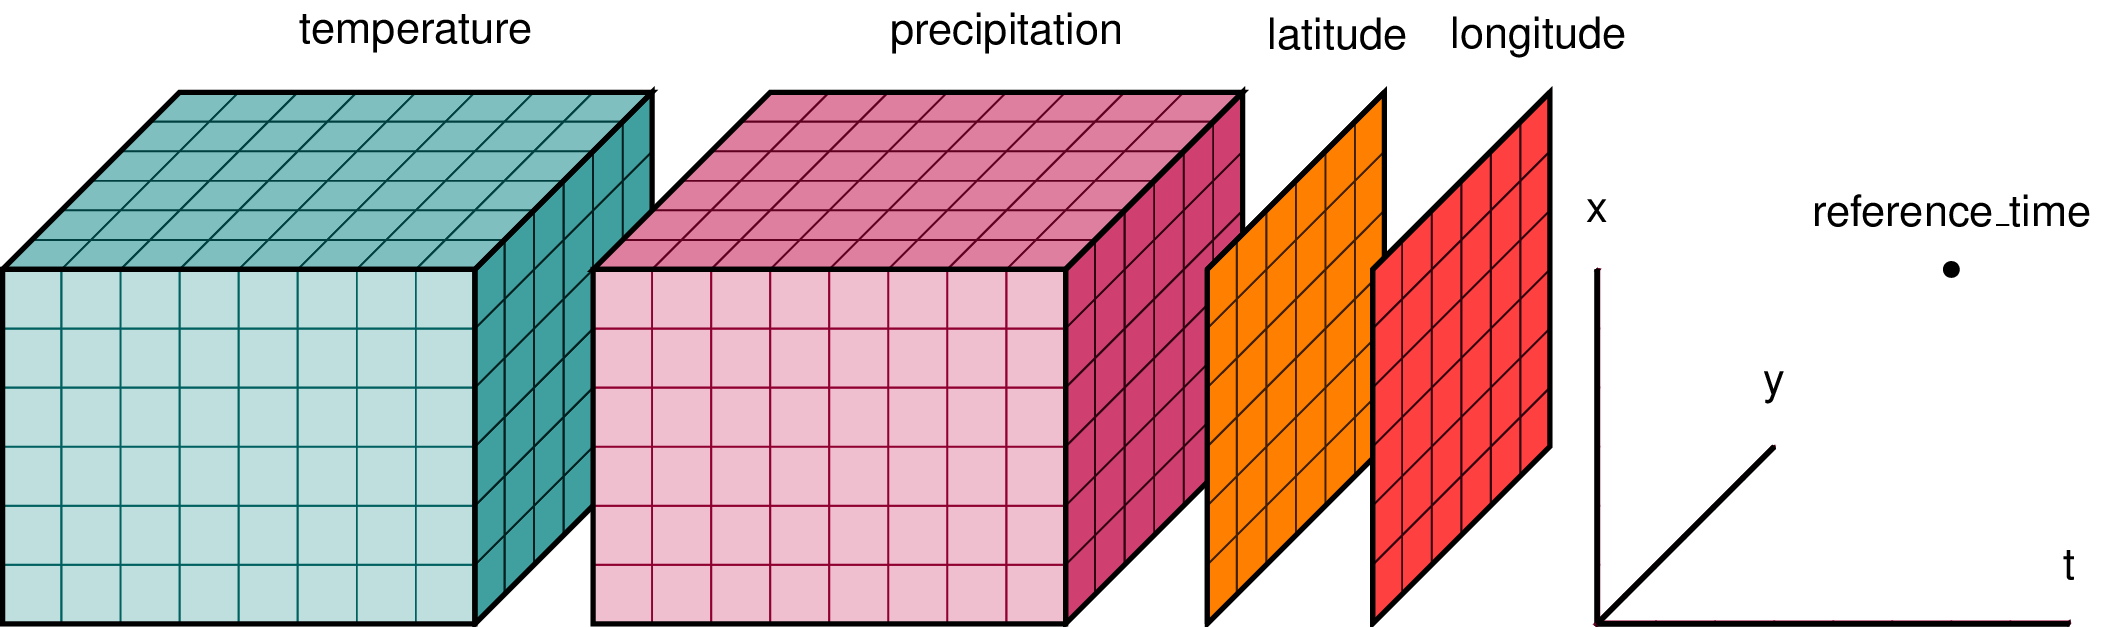


Even though the graph above has nothing to with the paper, the diagram (taken from x-array documentation website) illustrates the structure of xarray data (a Dataset in this case) works. In this example, we have the **axis** (x, y, t), **data** (temperature, precipitation, y, x). The latitude (y) and longitude (x) label the points along the dimensions, so they are the 'coordinate_data', while temperature and precipitation are 'actual' variables in a dataset. The latitude and longitude are 2D data in this case because the example used map projection. There can be an infinite amount of variables, but it would be unwise to have lots of axes and coordinates.

### 2.2.1 Explore the dataset of hurricanes and related systems

Run the code below to see an example of information that can be obtained from the original data.\
Read the output of the following code chunks to see some examples of operations we can carry out on the dataset.

In [8]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

## Print the tks to take a peek at what's actually in the dataset.
tks

<xarray.Dataset> Size: 618MB
Dimensions:           (storm: 2344, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 7MB ...
    lat               (storm, date_time) float32 3MB ...
    lon               (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 9kB ...
    sid               (storm) |S13 30kB ...
    season            (storm) float32 9kB ...
    number            (storm) int16 5kB ...
    basin             (storm, date_time) |S2 2MB ...
    subbasin          (storm, date_time) |S2 2MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 3MB ...
    reunion_gust_per  (storm, date_time) float32 3MB ...
    usa_seahgt        (storm, date_time) float32 3MB ...
    usa_searad        (storm, date_time, quadrant) float32 14MB ...
    storm_speed       (storm, date_time) float32 3MB ...
    storm_dir         (storm, date_time) float32 3MB ...
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

All the **coordinates** and **data variables** must align along the dimensions. **Attributes**, however, doesn't have to have shapes that aligned with at least one of the axes. It serves as a more auxiliary role in the dataset and provide other information that might be helpful.\
To obtain any variable from the dataset, for example 'xxx', use ***tks.xxx***.

In [9]:
# for example, Storm_speed
tks.storm_speed

<xarray.DataArray 'storm_speed' (storm: 2344, date_time: 360)> Size: 3MB
[843840 values with dtype=float32]
Coordinates:
    time     (storm, date_time) float64 7MB ...
    lat      (storm, date_time) float32 3MB ...
    lon      (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time
Attributes:
    long_name:              Storm translation speed
    units:                  kts
    valid_min:              0
    valid_max:              998
    coverage_content_type:  physicalMeasurement

In [ ]:
## how many tracks in total, this is the same as the length of the dimension 'storm'
storm_num = tks.dims['storm']

## Note that the dimension 'quadrant' is often not used, which can be
## dropped if wanted by tks.drop_dims("quadrant")
print(f"\nDimension of the dataset is {dict(tks.dims)}")
print(f"\nIn total, there are {storm_num} track records.")
print(f"\nThe attributes of this dataset are:\n {list(tks.attrs.keys())}")


## starting and ending season (the same as year)
min_year = np.array(np.min(list(tks.season)), dtype=int)
max_year = np.array(np.max(list(tks.season)), dtype=int)

print(f"\nTrack records start in year {min_year} and ends in year {max_year}")

## Print all the variables in a list.
print('\nAll variables in this dataset:')
print(list(tks.keys()))


## Print a sentence that contians some summary information.
storm_1 = tks.sel(storm=2000) # notice that the first storm starts with 0 not 1
name = str(storm_1.name.values)[2:-1] # use this trick to obtain the name string
sid = str(storm_1.sid.values,'UTF-8')
print(f"\nThe 2001st hurricane, named {name}, has a record of {int(storm_1.numobs)} \
observations with sid {sid} in year {int(storm_1.season)}.")


Dimension of the dataset is {'storm': 2344, 'date_time': 360, 'quadrant': 4}

In total, there are 2344 track records.

The attributes of this dataset are:
 ['title', 'summary', 'source', 'Conventions', 'Conventions_note', 'product_version', 'project', 'processing_level', 'acknowledgement', 'references', 'institution', 'publisher_type', 'publisher_name', 'publisher_email', 'publisher_institution', 'publisher_url', 'creator_type', 'creator_name', 'creator_institution', 'creator_email', 'creator_url', 'contributor_name', 'contributor_role', 'date_created', 'date_issued', 'time_coverage_start', 'time_coverage_end', 'geospatial_lat_min', 'geospatial_lat_max', 'geospatial_lat_units', 'geospatial_lat_resolution', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lon_units', 'geospatial_lon_resolution', 'geospatial_vertical_min', 'geospatial_vertical_max', 'naming_authority', 'id', 'metadata_link', 'keywords', 'keywords_vocabulary', 'standard_name_vocabulary', 'history', 'license', 'fea

\\

---

\\

## 2.3 Visualizing a track or group of tracks

We use asterisk and X to denote the birth and death points of a track.

In [11]:
# These are helper functions to conveniently plot one single track.
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# !!! Note that even though it's a convention to place latitude before longitude,
# to work with cartopy projection, longitude MUST be placed first. !!!
def plot_one_track(ax, storm, color='blue', all_track=True, marker_color='black'):
  # INPUT:
  # ax: Matplotlib axes object
  # storm: a Xarray DATASET object (this can be adjusted if desired)
  # all_track: plot the whole track or just the origin

  # OUTPUT:
  # None

  lon_lst, lat_lst = get_lon_lat(storm)
  year = storm.season.values
  if all_track:
    ax.plot(lon_lst, lat_lst, '-o', color=color, linewidth=2, markersize=3) # marker='.'
    ax.plot(lon_lst[-1], lat_lst[-1], color=marker_color, marker='x', markersize=10)
  ax.plot(lon_lst[0], lat_lst[0], color=marker_color, marker='*', markersize=10)
  ax.text(lon_lst[0], lat_lst[0]-2, str(storm.name.values)[2:-1], horizontalalignment='center')



## 2.3.1 Visualize all tracks in a year


Use function to visualize all tracks in year 2017 (or whichever year you choose on first line)

There are 19 storms in the year 2017.



Text(0.5, 1.0, 'Tracks in year 2017')

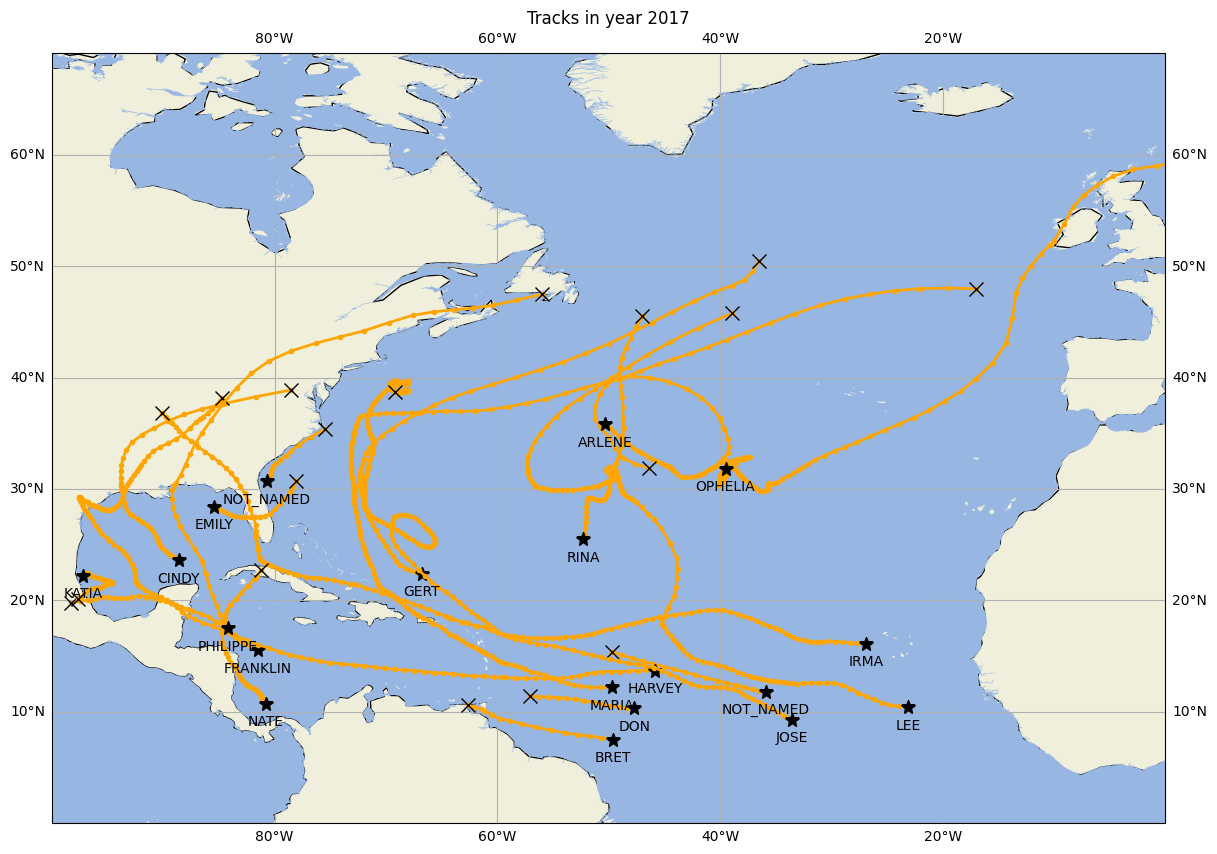

In [12]:
year=2017 # Change this to see tracks from other years.
storms = tks.where(tks.season==year, drop=True) # select the hurricanes that happened in selected year
print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Tracks in year {year}")
# plt.legend()

# PDI exploration

I (Andrew) am exploring the dataset a bit to see how hurricane intensity data is stored, and to test out calculating PDI.

Here I think we will find wind speed by calling `tks.wmo_wind`. PDI is defined as:

$$
PDI = \int\limits_{1}^{n} V^3 dt
$$

where n is the number of time steps within dt in seconds and V is the wind velocity in meters per second.

In [13]:
tks.wmo_wind

<xarray.DataArray 'wmo_wind' (storm: 2344, date_time: 360)> Size: 3MB
[843840 values with dtype=float32]
Coordinates:
    time     (storm, date_time) float64 7MB ...
    lat      (storm, date_time) float32 3MB ...
    lon      (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time
Attributes:
    long_name:              Maximum sustained wind speed from Official WMO ag...
    units:                  kts
    coverage_content_type:  physicalMeasurement

As we can see above, the units of `tks.wmo_wind` are knots. We first need to convert to meters per second before proceeding to the rest of the steps. (Thank you Wikipedia for the conversion: https://en.wikipedia.org/wiki/Knot_(unit))

In [14]:
velocity = tks.wmo_wind * 0.51444
velocity

<xarray.DataArray 'wmo_wind' (storm: 2344, date_time: 360)> Size: 3MB
array([[    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [41.1552,     nan,     nan, ...,     nan,     nan,     nan],
       ...,
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]],
      shape=(2344, 360), dtype=float32)
Coordinates:
    time     (storm, date_time) float64 7MB ...
    lat      (storm, date_time) float32 3MB ...
    lon      (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time

In [17]:
import pandas as pd

In [502]:
def calculate_pdi(storm):
    """
    Calculate the Power Dissipation Index (PDI) from an xarray DataArray.

    Parameters:
    da (xarray.DataArray): DataArray containing wind speed data with a time dimension.
    wind_speed_col (str): Name of the wind speed column we will use.

    Returns:
    float: PDI value in units of m^3/s^2
    """
    # Convert to pandas DataFrame
    df = storm.drop_dims("quadrant").to_dataframe()

    # Ensure index is datetime
    time = pd.to_datetime(df['iso_time'].str.decode("utf-8"))
    
    wind_speed = storm["wmo_wind"].values * 0.51444

    # Cube the wind speeds
    wind_speed_cubed = np.power(wind_speed, 3)

    # Calculate time differences in seconds
    time_diff = time.diff().dt.total_seconds()

    # Compute PDI using Riemann sum
    pdi = np.sum(wind_speed_cubed * time_diff)

    return pdi*10**-11



In [503]:
# scatter plot the PDI for all storms
pdi_lst = []
for i in range(2344):
    pdi = calculate_pdi(tks.sel(storm=i))
    pdi_lst.append(pdi)

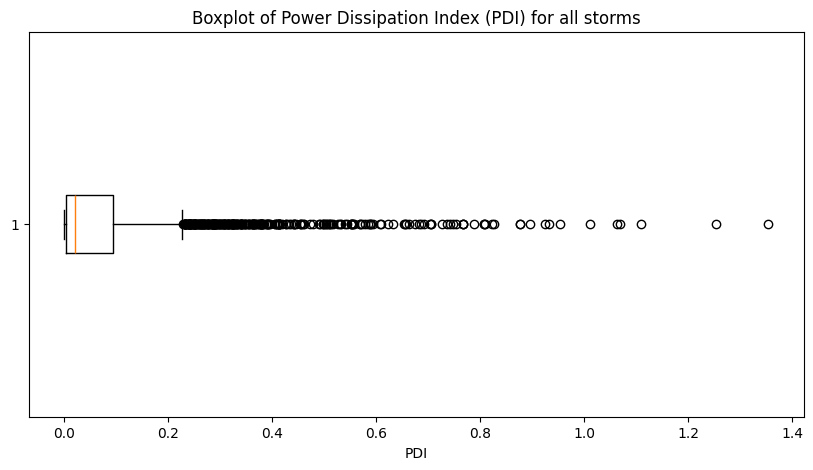

In [496]:
# create box plot for PDI
plt.figure(figsize=(10, 5))
plt.boxplot(pdi_lst, vert=False)
plt.xlabel('PDI')
plt.title('Boxplot of Power Dissipation Index (PDI) for all storms')
plt.show()


In [497]:
pdi_dataframe = pd.DataFrame(pdi_lst, columns=['PDI'])
pdi_dataframe.index.name = 'Storm'

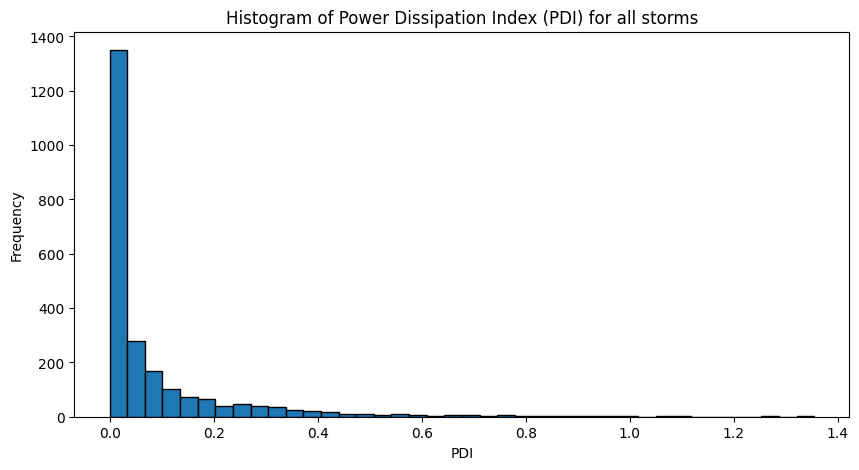

In [498]:
# histogram of PDI
plt.figure(figsize=(10, 5))
plt.hist(pdi_lst, bins=40, edgecolor='black')
plt.xlabel('PDI')
plt.ylabel('Frequency')
plt.title('Histogram of Power Dissipation Index (PDI) for all storms')
plt.show()

In [499]:
# plotting total pdi for each year

years = np.arange(1950, 2010)
pdi_year = []
for year in years:
    storms = tks.where(tks.season==year, drop=True)
    pdi_lst = []
    for i in range(storms.dims['storm']):
        pdi = calculate_pdi(storms.sel(storm=i))
        pdi_lst.append(pdi)
    pdi_year.append(np.sum(pdi_lst))

plt.figure(figsize=(10, 5))
plt.scatter(years, pdi_year)
plt.xlabel('Year')
plt.ylabel('Total PDI')
plt.title('Total Power Dissipation Index (PDI) for each year')
plt.show()


KeyboardInterrupt: 

\\

---

\\

# Step 3: Analyze Tracks

Here we use moment as a numerical characteristic of a track. [Ophelia (2005)](https://en.wikipedia.org/wiki/Hurricane_Ophelia_(2005)) is given as an example track.



## 3.1 Define the moments of a track

Below codes plot ONE track and its moments based on the paper's idea.

So, what we want to do here is to find a summary statistics for the track. Here the method below calculates the weighted first and second moments of a track, which would ouput a 5-entry vector which can be used in clustering and analysis purpose.

M1 here stands for the first moment. When the weights $w$ are set to 1, it simply calculating the means of the longitude and latitude vectors. Changing the weights to other variables, such as wind speed, storm speed, temperatures, etc. should result in different clustering. In the paper, setting all the weights to 1 is used.

M2 stands for the second moment. When the weights are 1, it is calculating the variances and covariance of longitude and latitude vectors of a given track.

$r$ is a two-dimensional vector that corresponds to $(x,y)$, i.e., longitude and latitude.

See [Nakamura et al (2009)](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) for more details on the notation.

$$
\begin{aligned}
\mathbf{M 1}&=\frac{1}{A} \int w(\mathbf{r}) \mathbf{r} d x d y=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right) \mathbf{r}_{i} \\
\mathbf{M 2} &=\frac{1}{A} \int w(\mathbf{r})(\mathbf{r}-\mathbf{M 1})^{2} d x d y
=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right)\left(\mathbf{r}_{i}-\mathbf{M 1}_{i}\right)^{2}
\end{aligned}
$$


## 3.1.1 Function to calculate moment for a system

This function outputs a length-5 vector that summaries the moments of a track as specified in the above description.


In [394]:
def get_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])

  # pdi = calculate_pdi(storm)
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

## 3.1.2 Calculate moments and visualize for one system

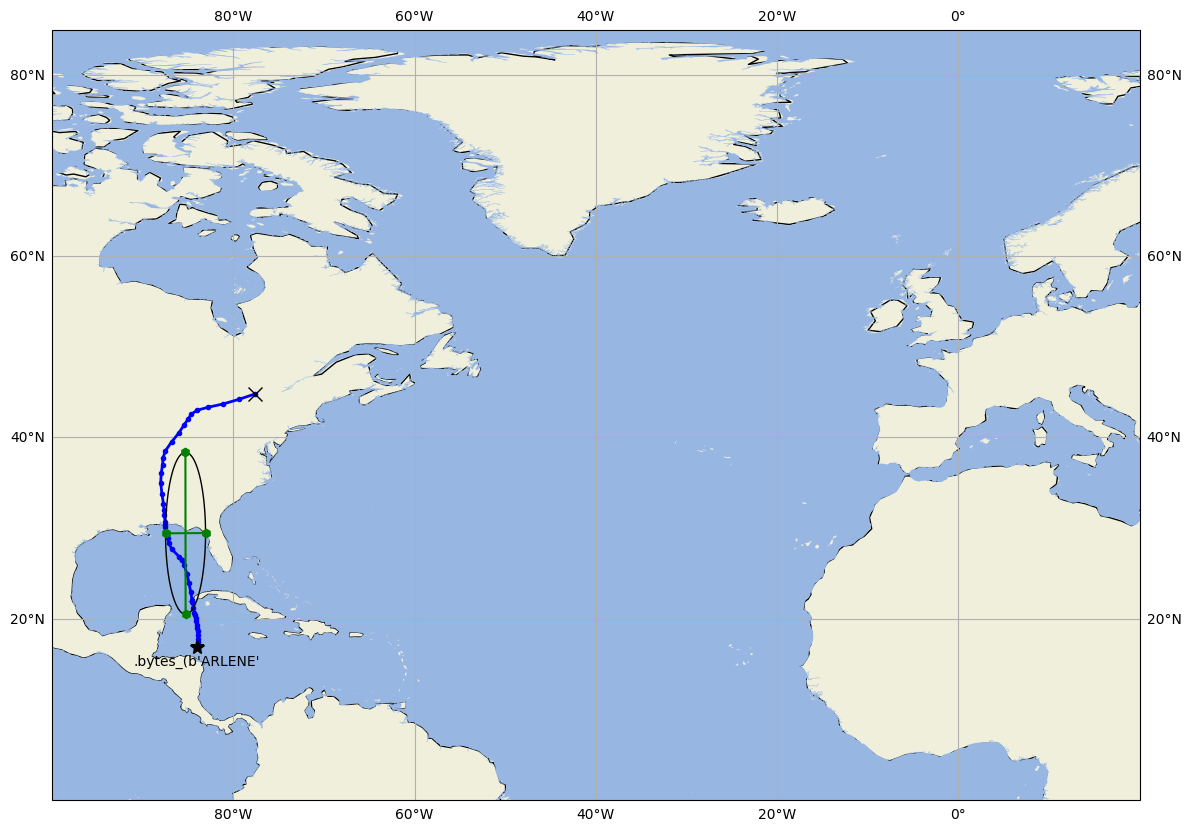

In [388]:
storm = tks.sel(storm=2000)
lon_weighted, lat_weighted, lon_var, lat_var, xy_var, _ = get_moments(storm)

# Rotate the circle and calculate points on the circle
# Set N larger to make the oval more precise and to consume more electricity
N=1000
t = np.linspace(0, 2 * np.pi, N)
circle = [np.sqrt(lon_var) * np.cos(t), np.sqrt(lat_var) * np.sin(t)]
_, R_rot = LA.eig(np.array([[lon_var, xy_var], [xy_var, lat_var]]))
circle = np.dot(R_rot, circle)
R_1, R_2 = circle[0, :] + lon_weighted, circle[1, :] + lat_weighted

# Plot
ax = map_background(extent=[-100, 20, 0, 80], label=True)
plot_one_track(ax, storm)
ax.plot(R_1, R_2, '-', color='black', linewidth=1)
ax.plot([circle[0,0], circle[0,int(N/2)]]+lon_weighted,
        [circle[1,0], circle[1,int(N/2)]]+lat_weighted, '-gh')
ax.plot([circle[0,int(N/4)], circle[0,int(N*3/4)]]+lon_weighted,
        [circle[1,int(N/4)], circle[1,int(N*3/4)]]+lat_weighted, '-gh')

## 3.2 K-means clustering using moments for all systems

In this section, K-means clustering is carried out on the historical tracks with the idea adopted from the paper. As the data are different, nuances with the clustering results are expected.

In [395]:
# It takes a moment to calculate the moments.
moment_lst = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if get_moments(tks.sel(storm=i))]
print(np.shape(moment_lst))
print(f"There are {tks.dims['storm']-np.shape(moment_lst)[0]} tracks that have length less than 1.")

(2315, 5)
There are 29 tracks that have length less than 1.


### 3.2.1 Find inertia values to determine the right number of clusters

Run the clustering for a range of cluster numbers and extract the interia value

Inertia values from sklearn are evaluated with the "elbow method" to determine the optimal value of the clusters.\
Inertia, or cost, is calculated as the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. See the documentation for [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for more details.

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

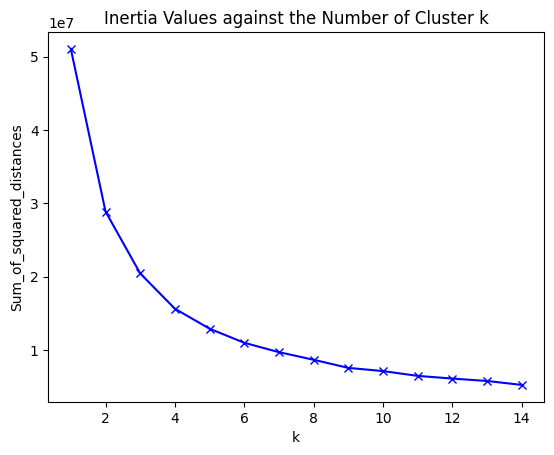

In [396]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

From the plot above, 6 is probably a good choice for the number of clusters.\
Below codes plot the K-means results. The locations on the map are the weighted first moment of the hurricane tracks. In the example code, the weights were set to be 1 meaning that the first moment is the sample mean (see section 3.1 description).

Note that if you run the code again the ordering of the clusters changes

Text(0.5, 1.0, 'K-means clustering result, 6 clusters')

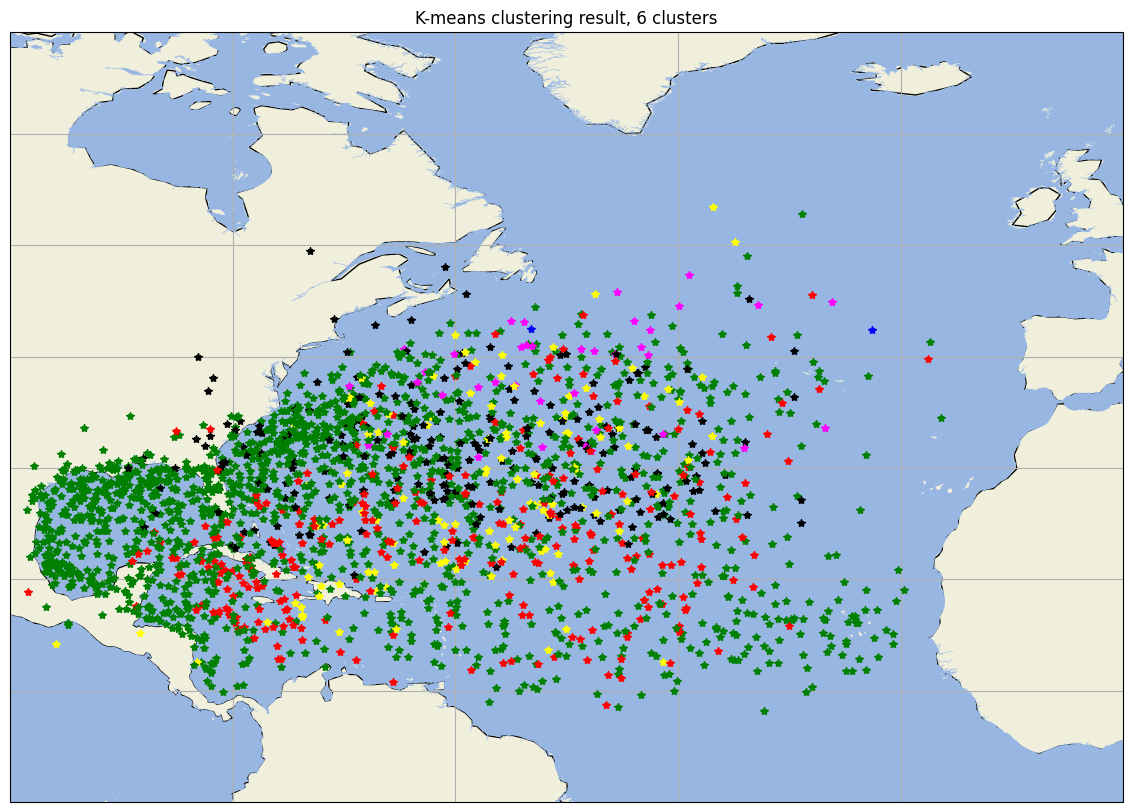

In [486]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result, 6 clusters')

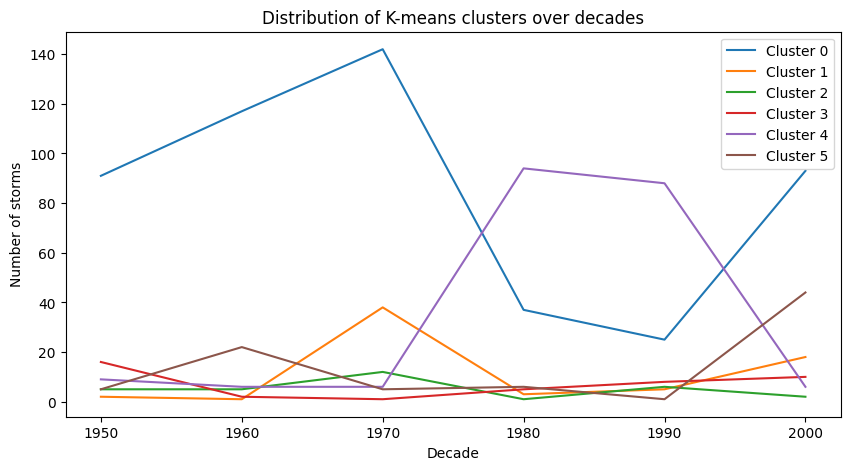

In [ ]:
# calculate distribution of k means clusters over decades

decades = np.arange(1950, 2010, 10)
cluster_distribution = np.zeros((6, len(decades)))
for i, decade in enumerate(decades):
    storms = tks.where((tks.season >= decade) & (tks.season < decade + 10), drop=True)
    moment_lst = [get_moments(storms.sel(storm=i)) for i in range(storms.dims['storm'])
                  if get_moments(storms.sel(storm=i))]
    km = k_means(moment_lst, n_clusters=6)
    labels = km[1]
    for label in labels:
        cluster_distribution[label, i] += 1

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.plot(decades, cluster_distribution[i], label=f'Cluster {i}')
plt.xlabel('Decade')
plt.ylabel('Number of storms')
plt.title('Distribution of K-means clusters over decades')
plt.legend()
plt.show()



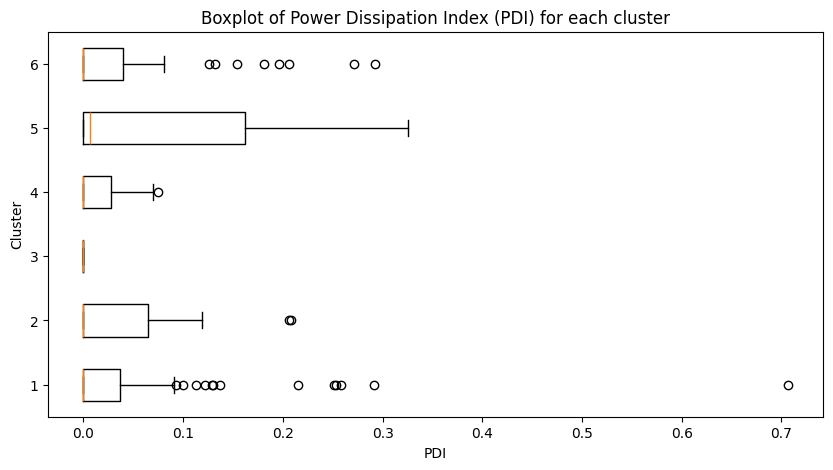

In [ ]:
# plot clusters on x axis and pdi on y axis and show distribution of pdi in each cluster using boxplot

cluster_pdi = [[] for i in range(6)]
for i in range(len(labels)):
    cluster_pdi[labels[i]].append(pdi_lst[i])

plt.figure(figsize=(10, 5))
plt.boxplot(cluster_pdi, vert=False)
plt.xlabel('PDI')
plt.ylabel('Cluster')
plt.title('Boxplot of Power Dissipation Index (PDI) for each cluster')
plt.show()


Text(0.5, 1.0, 'K-means clustering result')

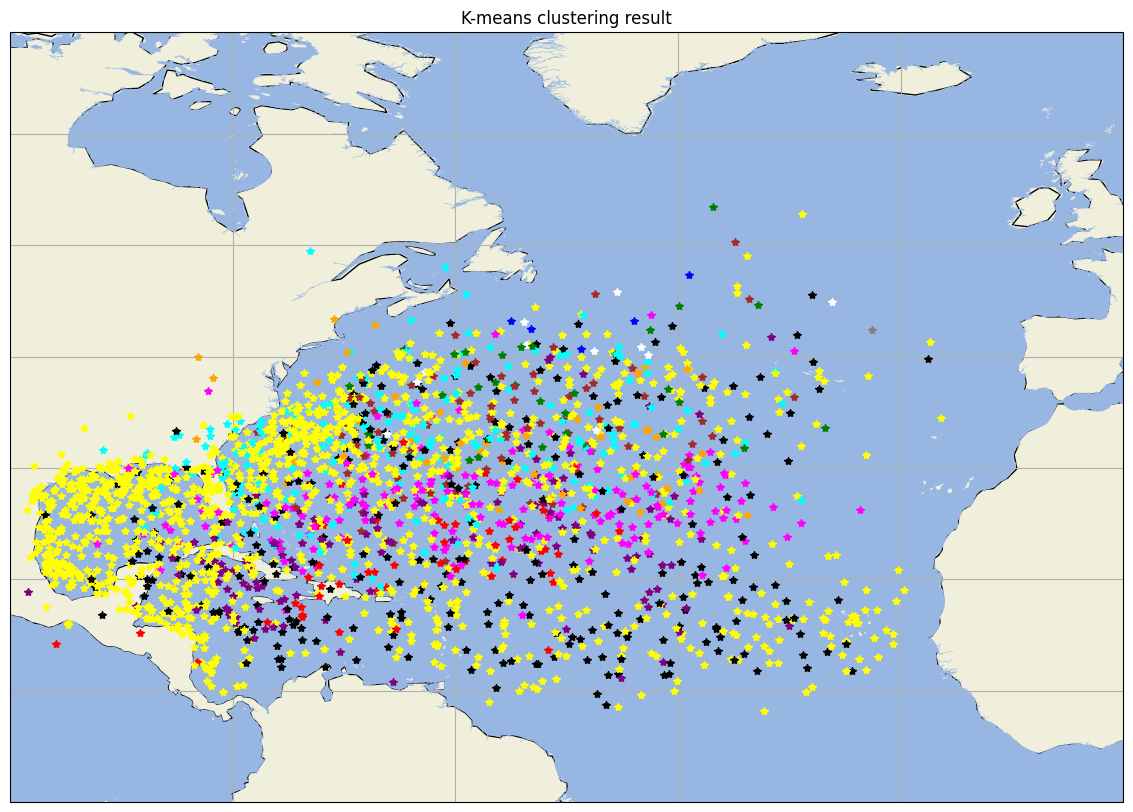

In [ ]:
# consider a different number of clusters (colors set for up to 12, add more colors if you want more clusters)
km = k_means(moment_lst, n_clusters=12)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta','orange','gray','white','cyan','purple','brown']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result')

## GMM clustering using moments for all systems

Text(0.5, 1.0, 'Gaussian Mixture Model clustering result, 6 clusters')

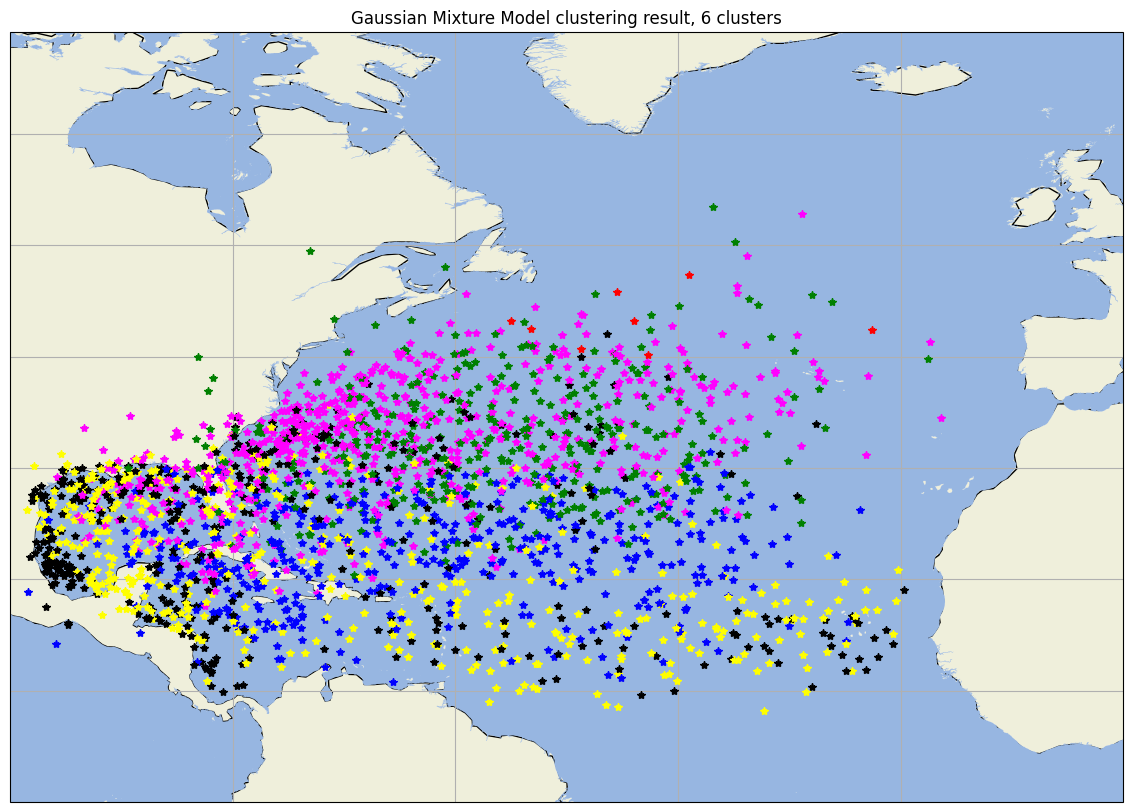

In [463]:
# gaussian mixture model clustering

from sklearn.mixture import GaussianMixture

colors = ["black", "red", "blue", "yellow", "green", "magenta"]
gmm = GaussianMixture(n_components=6)
gmm.fit(moment_lst)
gmm_labels = gmm.predict(moment_lst)
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[gmm_labels[k]], marker="*")
plt.title('Gaussian Mixture Model clustering result, 6 clusters')


### Comparing K-means and GMM clustering

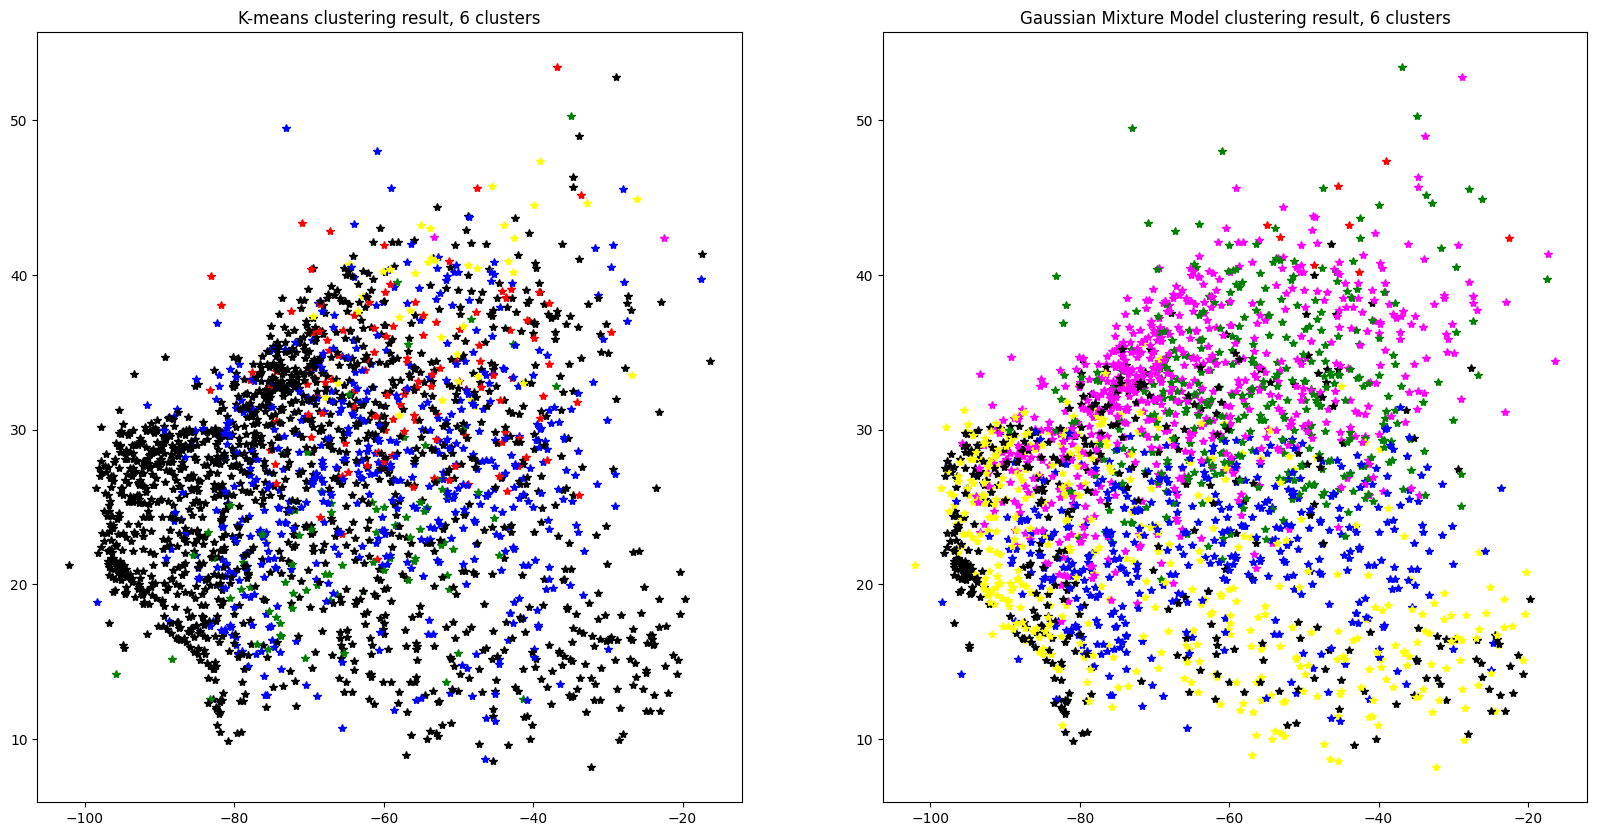

In [464]:
# compare the two clustering methods

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].set_title('K-means clustering result, 6 clusters')
axs[1].set_title('Gaussian Mixture Model clustering result, 6 clusters')
for k in range(len(moment_lst)):
    axs[0].plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
    axs[1].plot(moment_lst[k][0], moment_lst[k][1], c=colors[gmm_labels[k]], marker='*')
    

In [483]:
# compare the two clustering methods using the davies bouldin score

from sklearn.metrics import davies_bouldin_score

db_score_kmeans = davies_bouldin_score(moment_lst, labels)
db_score_gmm = davies_bouldin_score(moment_lst, gmm_labels)

print(f"Davies Bouldin score for K-means clustering: {db_score_kmeans}")
print(f"Davies Bouldin score for Gaussian Mixture Model clustering: {db_score_gmm}")

Davies Bouldin score for K-means clustering: 0.9272707752879331
Davies Bouldin score for Gaussian Mixture Model clustering: 1.1829500019738983


The Davies Bouldin Index is a relative score, meaning that it can be used to compare different clustering methods on the same dataset. The lower the score, the better the clustering. The score is defined as:

$$
DBI = \frac{1}{n} \sum_{i=1}^{n} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$

where $n$ is the number of clusters, $\sigma_i$ is the average distance between points in cluster $i$ and the centroid of cluster $i$, and $d(c_i, c_j)$ is the distance between the centroids of clusters $i$ and $j$. The DBI is a measure of the average similarity between each cluster and its most similar cluster.

As we can see from the above cell, K-means clustering has a lower DBI score than the Gaussian Mixture Model. This means that K-means clustering is a better fit for this dataset.


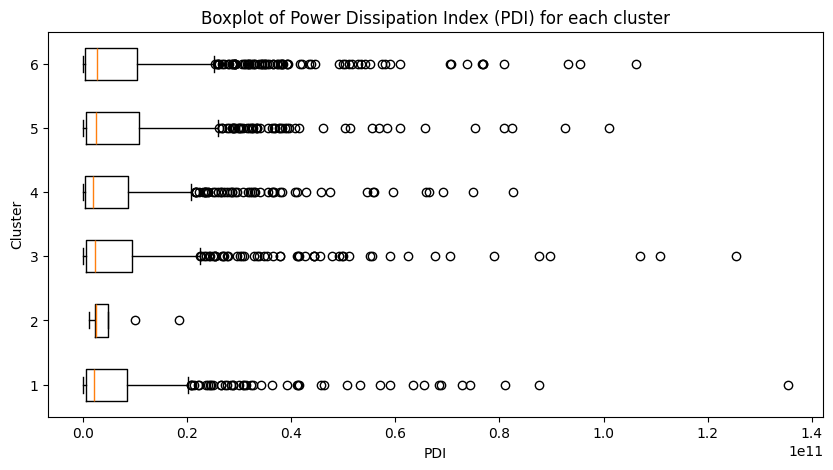

In [473]:
# plot clusters on x axis and pdi on y axis and show distribution of pdi in each cluster using boxplot

cluster_pdi = [[] for i in range(6)]
for i in range(len(labels)):
    cluster_pdi[gmm_labels[i]].append(pdi_lst[i])

plt.figure(figsize=(10, 5))
plt.boxplot(cluster_pdi, vert=False)
plt.xlabel("PDI")
plt.ylabel("Cluster")
plt.title("Boxplot of Power Dissipation Index (PDI) for each cluster")
plt.show()


## 3.5 Other Summary Statistics and example comparisons

### 3.5.1 Distance traveled

Compare the $\Delta$ lon and $\Delta$ lat between these two interval of years (2000\~2010 against 1990\~1999).\
$\Delta$ lon is the maximum value of distance of travel of a hurricane from its start to its end location in its longitude (same as the what [np.ptp](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html) does).

194 storms between year 2000 and 2010,         133 storms between year 1990 and 1999.



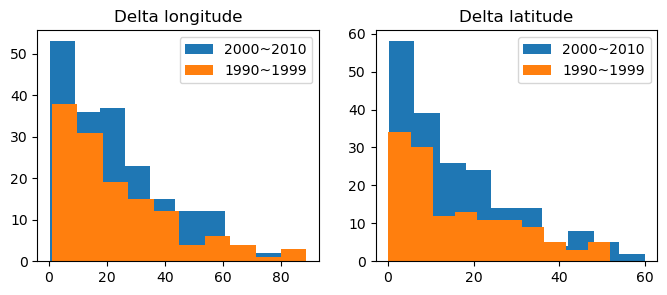

In [26]:
def delta_lon_lat(storm):
  lon_lst, lat_lst = get_lon_lat(storm)
  return [np.ptp(lon_lst), np.ptp(lat_lst)]

storms_1 = tks.where((tks.season >= 2000) & (tks.season <= 2010), drop=True)
storms_2 = tks.where((tks.season >= 1990) & (tks.season <= 1999), drop=True)
N1, N2 = storms_1.dims['storm'], storms_2.dims['storm']
print(f"{storms_1.dims['storm']} storms between year 2000 and 2010, \
        {storms_2.dims['storm']} storms between year 1990 and 1999.\n")

d_lst_1 = [delta_lon_lat(storms_1.sel(storm=i)) for i in range(N1)]
d_lst_1 = np.transpose(d_lst_1)

d_lst_2 = [delta_lon_lat(storms_2.sel(storm=i)) for i in range(N2)]
d_lst_2 = np.transpose(d_lst_2)


fig, axs = plt.subplots(1,2,figsize=(8,3)) # gridspec_kw={'height_ratios': [1, 2]}

for j in range(2):
  axs[j].hist(d_lst_1[j], label='2000~2010')
  axs[j].hist(d_lst_2[j], label='1990~1999')
  axs[j].legend()
axs[0].title.set_text('Delta longitude')
axs[1].title.set_text('Delta latitude')



It can be seen from the above graphs that hurricanes traveled greater distance in 2000\~2010 compared to 1990~1999.

### 3.5.2 Naming hurricanes

Many hurricane in the data set have a name. We use the codes below to visualize the predominant gender of the names used.

Here is some [history of the hurricane naming system](https://www.nhc.noaa.gov/aboutnames_history.shtml):

+ 1953 - 1977: The United States only used female names for hurricanes.
+ 1978 - present: Both female and male names are used.

We use the [gender.Detector](https://pypi.org/project/gender-guesser/) to automatically infer the predominant gender of each name found in the data set.

Note that in the output below, a very few percentage of names are marked 'Andy' which means it's a gender-neutral or an unisex name (are you woke enough?).

Ophelia is deemed a female name.

In total there are 226 named hurricanes during 1953-1979.

In total there are 589 named hurricanes after 1979.



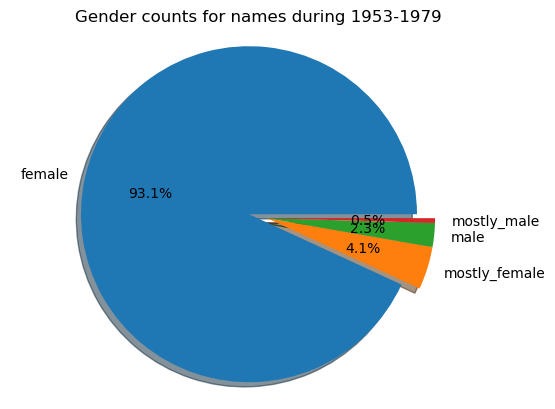

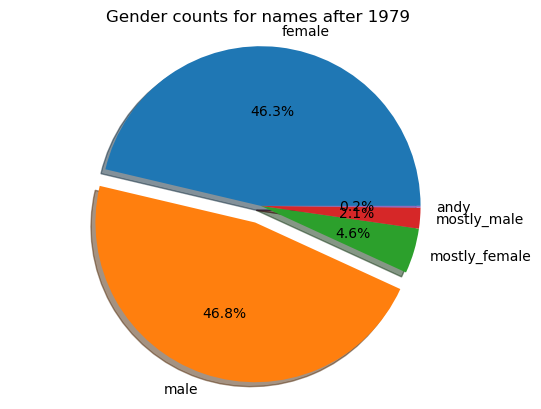

In [27]:
def plot_pie_chart(storms, period):
  # a function to plot pie chart the genders of names given a bunch of storms

  all_names = [str(name)[2:-1] for name in storms.name.values]
  all_names = [x for x in all_names if x!='NOT_NAMED'] # clean the unnamed cases
  print(f"In total there are {len(all_names)} named hurricanes {period}.\n")

  gender_lst = [d.get_gender(name) for name in all_names]
  gender_lst = [x for x in gender_lst if x!='unknown'] # clean the unknown names

  # Data (counts)
  genders_category = Counter(gender_lst).keys()  # equals to list(set(list))
  genders_count = Counter(gender_lst).values() # counts the elements' frequency
  explode = [0.11 if x==max(genders_count) else 0 for x in genders_count]

  # plot
  fig1, ax1 = plt.subplots()
  ax1.pie(genders_count, explode=explode, labels=genders_category, autopct='%1.1f%%',
          shadow=True, startangle=0)
  ax1.axis('equal')
  ax1.title.set_text(f'Gender counts for names {period}')



d = gender.Detector(case_sensitive=False)
gen = d.get_gender("Ophelia")
print(f"Ophelia is deemed a {gen} name.\n")
storms = tks.where((tks.season >=1953)&(tks.season <=1979), drop=True)
storms_1 = tks.where((tks.season >=1979), drop=True)

plot_pie_chart(storms, period='during 1953-1979')
plot_pie_chart(storms_1, period='after 1979')


### 3.5.3 Not all systems are hurricanes. Classification of systems - hurricane? tropical storm? tropical depression? 

Below codes summarize the types of all the classified hurricanes in the record (in the NA basin).

Storm classification by usa_status (according the documentation this is not the unique way of classifying the tracks)

Status of system. Options:
* DB - disturbance,
* TD - tropical depression,
* TS - tropical storm,
* TY - typhoon,
* ST - super typhoon,
* TC - tropical cyclone,
* HU,HR - hurricane,
* SD - subtropical depression,
* SS - subtropical storm,
* EX - extratropical systems,
* PT - post tropical,
* IN - inland,
* DS - dissipating,
* LO - low,
* WV - tropical wave,
* ET - extrapolated,
* MD - monsoon depression,
* XX - unknown.
 
documentation at https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_v04_column_documentation.pdf

In [28]:
all_types = tks.usa_status.values
print(np.shape(all_types))

(2344, 360)


Notice the shape is (2344, 360), indicating that the classification of each system evolves along the 'date_time' axis. \
To identify a class for system across its whole track, we can define it as the one class that has the highest frequency throughout its lifetime.


There are 2002 systems in the North Atlantic that were classified at least once during its lifetime.



Text(0.5, 1.0, 'Counts of the classification of all the tracks')

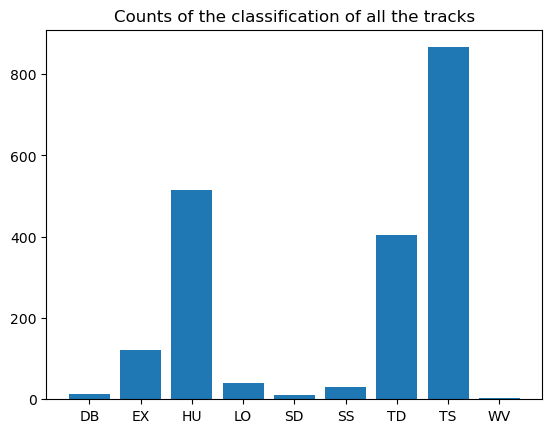

In [29]:
class_lst = []

for i in range(tks.dims['storm']):
  types = [str(x)[2:-1] for x in all_types[i]]
  types = [x for x in types if x!='']
  # many of the recorded tracks are never given a class
  if len(types)==0: continue
  class_category = Counter(types).most_common(1)[0][0] # Select the most frequent class
  class_lst.append(class_category)

print(f'There are {len(class_lst)} systems in the North Atlantic that were classified at \
least once during its lifetime.\n')

# This helps center the labels.
labels, counts = np.unique(class_lst, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Counts of the classification of all the tracks')

# References

+ Nakamura, Jennifer, et al. "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml).

+ Nakamura, Jennifer, et al. "Western North Pacific tropical cyclone model tracks in present and future climates." Journal of Geophysical Research: Atmospheres 122.18 (2017): [9721-9744](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JD027007).